# Multi Layer Perceptron

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-03-22 10:05:16.666151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7069076497472761732
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48974397440
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 11435544957634416321
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam

2023-03-22 10:02:25.073331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 10:02:25.223451: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 데이터 테이블 생성

In [2]:
import pandas as pd

review_df = pd.read_csv('../data/ulsan_rest_review_id.csv')
title_df = pd.read_csv('../data/ulsan_rest_title.csv')

In [3]:
print(review_df.isnull().sum())

review_df.dropna(axis=0, how='any', subset=['user_id'], inplace=True)

title         0
u_id          0
user_id      21
score         0
comment    1206
dtype: int64


In [4]:
table_df = pd.merge(review_df, title_df, on='title', how='inner')
table_df

,title,u_id,user_id,score,comment,p_id,rate,tags,address,url
0,바다바라기 본점,0,0,1,인생최악의 킹크랩 이였습니다. 게의 상태가 안좋은 건지 잘못찐건지.킹크랩의 고유의 ...,420,4.0,"게,대게","울산 북구 정자1길 111 1,2층 (우)44233",https://place.map.kakao.com/15261734
1,바다바라기 본점,21,-,1,진짜 돈아깝다음식이랑 직원한테 투자해야할걸 sns 광고비에만 몰빵하는듯어딜가든 여기...,420,4.0,"게,대게","울산 북구 정자1길 111 1,2층 (우)44233",https://place.map.kakao.com/15261734
2,바다바라기 본점,22,--,5,대게가 엄청큰데 살이 완전 가득 채워져있고 살이 부들부들해서 진짜 계속 먹을 수 있...,420,4.0,"게,대게","울산 북구 정자1길 111 1,2층 (우)44233",https://place.map.kakao.com/15261734
3,바다바라기 본점,33,(알 수 없음),5,평점이 좋길래 믿고 방문했어요대게도 신선하고 직원분들도 친절해서 기분 좋은 식사했네요,420,4.0,"게,대게","울산 북구 정자1길 111 1,2층 (우)44233",https://place.map.kakao.com/15261734
4,바다바라기 본점,39,.,5,울산여행와서 맛집검색해서 왔는데 맛있었습니다. #맛집 #성공적,420,4.0,"게,대게","울산 북구 정자1길 111 1,2층 (우)44233",https://place.map.kakao.com/15261734
...,...,...,...,...,...,...,...,...,...,...
6816,장군참치,3008,ㅈ,1,오마이갓 참치집이 아님 종업사기꾼,310,3.0,참치회,울산 남구 정동로80번길 19 (우)44712,https://place.map.kakao.com/2008161945
6817,도드람마을,3058,재민맘-김혜원,5,고기 육질이 좋네요~ 역시 차가 많은 이유가 있네용~ ^^,380,3.5,"육류,고기",울산 북구 진장로 85 (우)44250,https://place.map.kakao.com/26345203
6818,도드람마을,3140,정원,1,고기 골라 손에 쥐고 들어갔더니 안내를 안해줍니다.아무 자리에 가서 앉았더니 한참 ...,380,3.5,"육류,고기",울산 북구 진장로 85 (우)44250,https://place.map.kakao.com/26345203
6819,도드람마을,3405,"최고,최악만 메모하는 유니",5,상차림반찬들+고기질 다 너무좋아요북구사람이면 다 아는 넘나유명한곳직원분들도 다 친절하시고,380,3.5,"육류,고기",울산 북구 진장로 85 (우)44250,https://place.map.kakao.com/26345203


In [5]:
data_df = table_df[['u_id', 'p_id', 'score']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6821 entries, 0 to 6820
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u_id    6821 non-null   int64
 1   p_id    6821 non-null   int64
 2   score   6821 non-null   int64
dtypes: int64(3)
memory usage: 213.2 KB


### Train, Test split

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2, random_state=42)

In [6]:
n_users = data_df.u_id.unique().shape[0]
n_places = data_df.p_id.unique().shape[0]
print(n_users, n_places)

3869 528


In [7]:
tf.keras.backend.clear_session()

### callback

In [9]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

### Model

In [10]:
latent_dim = 50 ## 잠재요인

# Define inputs
place_input = Input(shape=[1],name='place-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
place_embedding_mlp = Embedding(n_places, latent_dim, name='place-embedding-mlp')(place_input)
place_vec_mlp = Flatten(name='flatten-place-mlp')(place_embedding_mlp)

user_embedding_mlp = Embedding(n_users, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
place_embedding_mf = Embedding(n_places + 1, latent_dim, name='place-embedding-mf')(place_input)
place_vec_mf = Flatten(name='flatten-place-mf')(place_embedding_mf)

user_embedding_mf = Embedding(n_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = Concatenate()([place_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = Dot(axes = 1, normalize=False)([place_vec_mf, user_vec_mf])
combine_mlp_mf = Concatenate()([pred_mf, pred_mlp])


# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, place_input], result)
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
model.summary()

2023-03-22 10:02:29.120615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 10:02:29.826602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 place-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 place-embedding-mlp (Embedding  (None, 1, 50)       26400       ['place-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 50)       193450      ['user-input[0][0]']         

### Model Trainning

In [11]:
history = model.fit(x=[train.u_id, train.p_id],y= train.score, validation_split=0.2, epochs=100, verbose=1, callbacks=[earlystopping])

Epoch 1/100
 18/137 [==>...........................] - ETA: 1s - loss: 14.2576

2023-03-22 10:02:33.131243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


137/137 [==============================] - 4s 12ms/step - loss: 6.3161 - val_loss: 2.4754
Epoch 2/100
137/137 [==============================] - 1s 10ms/step - loss: 1.8759 - val_loss: 2.3408
Epoch 3/100
137/137 [==============================] - 1s 10ms/step - loss: 0.7843 - val_loss: 2.2165
Epoch 4/100
137/137 [==============================] - 1s 10ms/step - loss: 0.5674 - val_loss: 2.1040
Epoch 5/100
137/137 [==============================] - 1s 10ms/step - loss: 0.3773 - val_loss: 2.0776
Epoch 6/100
137/137 [==============================] - 1s 10ms/step - loss: 0.2806 - val_loss: 2.0894
Epoch 7/100
137/137 [==============================] - 1s 10ms/step - loss: 0.2344 - val_loss: 2.1036
Epoch 8/100
137/137 [==============================] - 1s 10ms/step - loss: 0.2042 - val_loss: 2.0819
Epoch 9/100
137/137 [==============================] - 1s 10ms/step - loss: 0.1837 - val_loss: 2.0680
Epoch 10/100
137/137 [==============================] - 1s 10ms/step - loss: 0.1681 - val_loss

### Loss graph

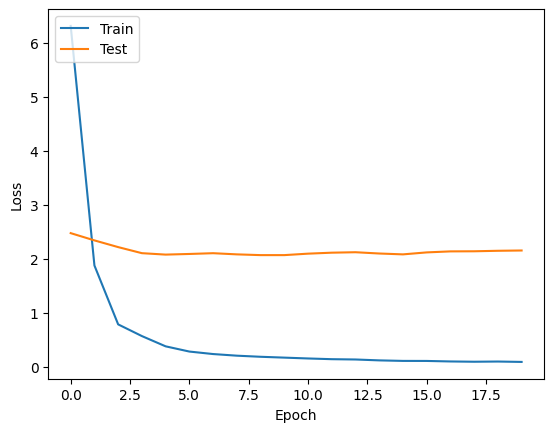

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.show()

In [13]:
model.evaluate([test.u_id, test.p_id], test.score)

43/43 [==============================] - 0s 3ms/step - loss: 2.1462


2.146177053451538

### 성능평가(RMSE)

In [14]:
from sklearn.metrics import mean_squared_error
y_prob = model.predict([test.u_id, test.p_id])
y_true = test.score
mean_squared_error(y_true, np.round(y_prob))**0.5

43/43 [==============================] - 0s 2ms/step


1.485460671506791